In this notebook, we aim at developing a basic classification model to predict the failure state of motor 6. The goal is to use this simple model to demonstrate some important ideas in training and deploying classification-based machine learning models for fault detection.

# Dataset

In this study, we consider develop a model to predict the label of motor 6. Please note that out of 23 datasets, there are only  seven datasets contains failure labels for motor 1. These seven datasets are collected from three operation modes:
- not moving: '20240425_093699', '20240425_094425', '20240426_140055'
- pickup and place: '20240503_163963', '20240325_155003'
- only moving the motor 6: '20240503_164675', '20240503_165189'

We are using a 5-fold cross validation to evaluate the performance of the developed classification model.

**Discussion**

Could you recall what is a 5-fold cross validation?

The following code reads all the datasets we specified above, and return a dataframe `df_data_experiment` that contains all the data we need for this study. You can have a look at the strucuture of this dataframe by using `df_data_experiment.head()`.

In [26]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline


# Subfunction for data preprocessing.
def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


# Ignore warnings.
warnings.filterwarnings('ignore')

# Read all the dataset.
base_dictionary = '../maintenance_industry_4_2024/dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

# Discussion 1: How should we design cross validation scheme?

Let us first try to implement a cross validation scheme so that we can evaluate the performance of the developed model. First, we use the `extract_selected_feature` function to seperate the features and the labels. 

In [27]:
from utility import extract_selected_feature

motor_id = 6
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
X, y = extract_selected_feature(df_data=df_data, feature_list=feature_list_all, motor_idx=motor_id, mdl_type='clf')
X = X.drop(columns=['test_condition'])

Now, we can design a conventionally 5-fold cross validatoin scheme. You can try the following prompt in Chatgpt or Mixtral Chat:

`I have a feature dataframe X and the corresponding y (a series). Please implement a 5-fold cross validation. In each run, train a logistic regression model, and return the accuracy on the test dataset. In the end, print the results of each run, and also the mean performance.`

In [28]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []

for train_index, test_index in kf.split(X):
    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Store the accuracy
    accuracies.append(accuracy)

print("Accuracy in each run: ", np.around(accuracies, decimals=3))
print("Mean accuracy: ", np.around(np.mean(accuracies), decimals=3))


Accuracy in each run:  [0.949 0.953 0.953 0.951 0.955]
Mean accuracy:  0.952


Here, the 5-fold cross validation seperates all the data into 5 folds, and run 5 experiments. In each experiment, it uses 6 folds of data to train the model, and evaluate the performance on the rest fold.

Do you think it is a reasonable evaluation scheme for our problem?

# Discussion 2: What would be the good performance metrics for imbalanced dataset?

As we discussed before, for a time-series problem like this, we should divide the different folds of data based on the sequence, not based on data points. The following code shows how to use a provided utility function to run cross validation based on sequences:

## Demo: How to use the utility function for cross validation.

### Basic usage

We can use `run_cv_one_motor` to easily run cross validation for one motor. For details of how to use this function, please have a look at its function signature (put your mouse on the function name will show the function signature). 

In the basic mode, we only need to specify values to four variables: `motor_idx, df_data, mdl, feature_list`.

For example, we could run a seven-fold cross validation with a logistic regression model using the following code:

Model for motor 6:

 New run:

training performance, accuracy is: 0.9342690140352106
training performance, precision is: 0.65
training performance, recall: 0.06055900621118013
training performance, F1: 0.11079545454545454



 New run:

testing performance, accuracy is: 0.9905941516111008
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




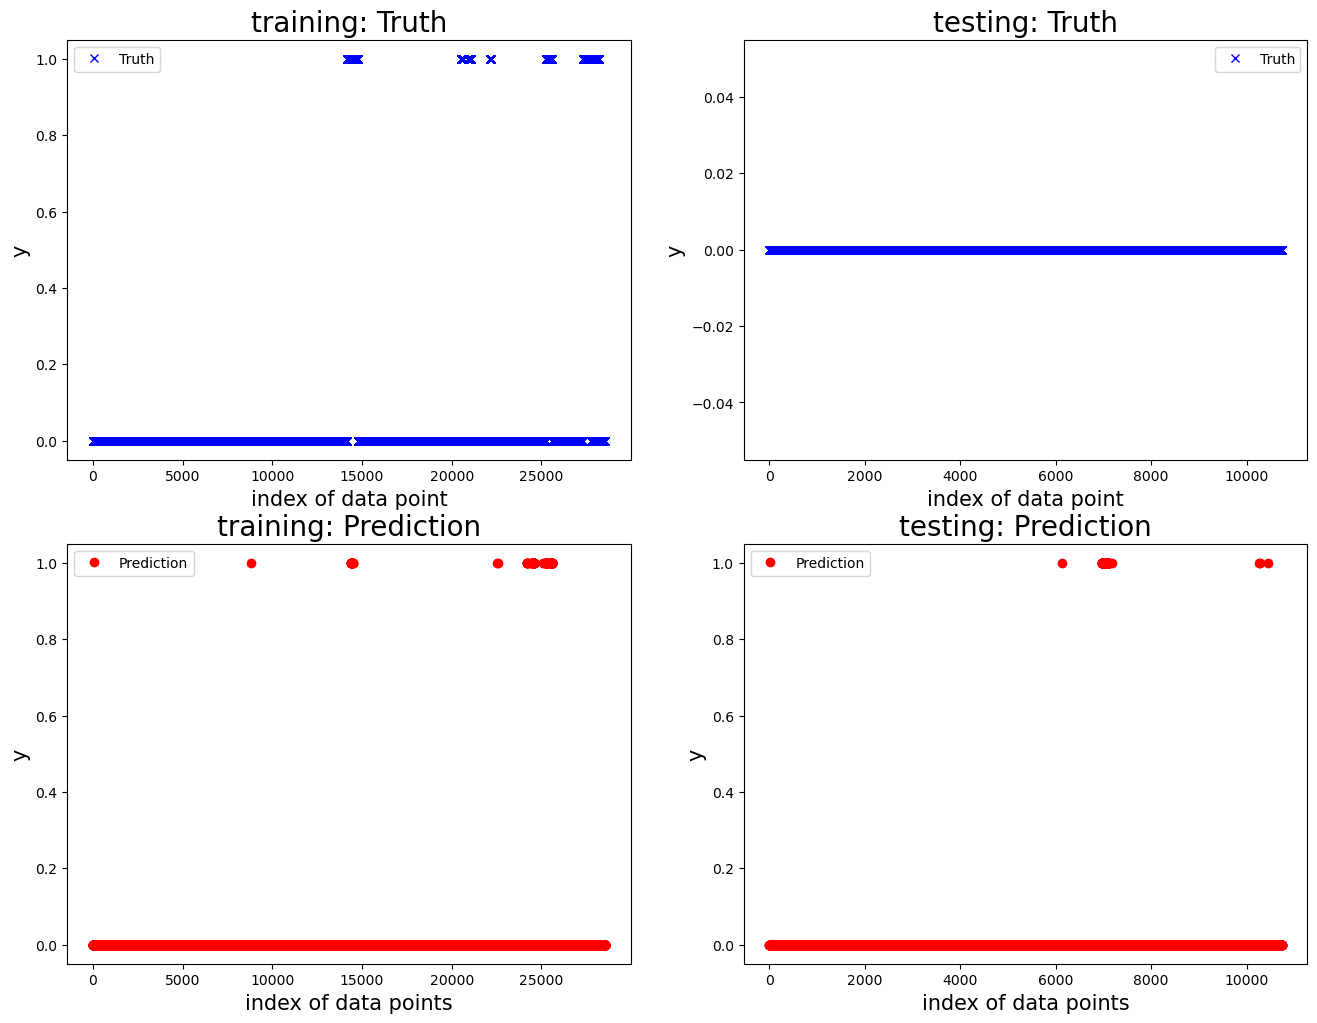


 New run:

training performance, accuracy is: 0.9333227580372251
training performance, precision is: 0.6120689655172413
training performance, recall: 0.10814927646610815
training performance, F1: 0.1838187702265372



 New run:

testing performance, accuracy is: 0.9694562925920478
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




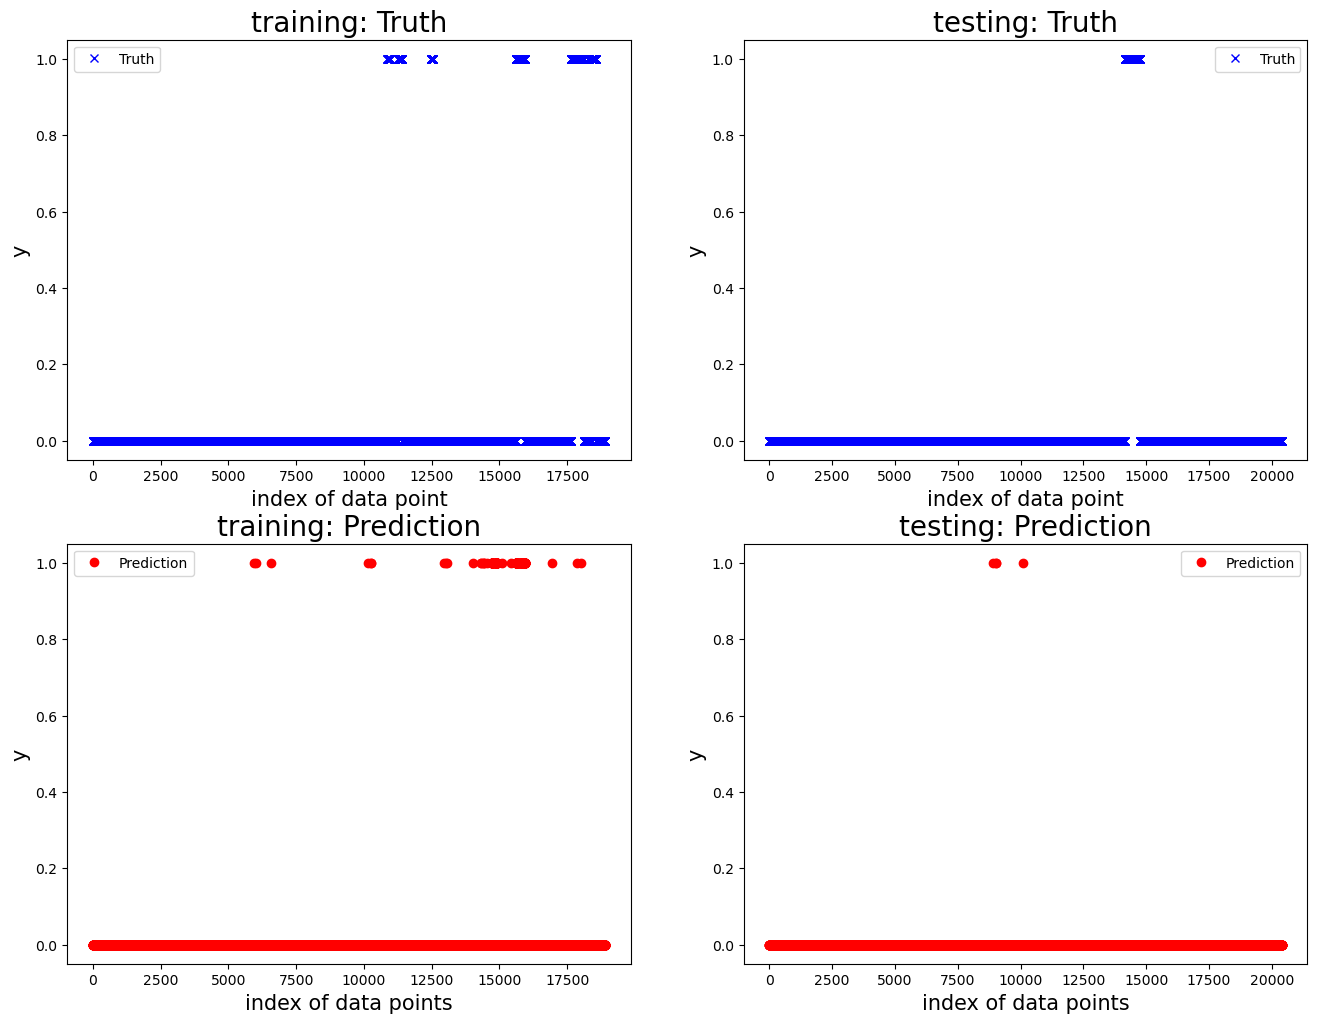


 New run:

training performance, accuracy is: 0.954368904909604
training performance, precision is: 0.5486381322957199
training performance, recall: 0.0850422195416164
training performance, F1: 0.1472584856396867



 New run:

testing performance, accuracy is: 0.9148211243611585
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




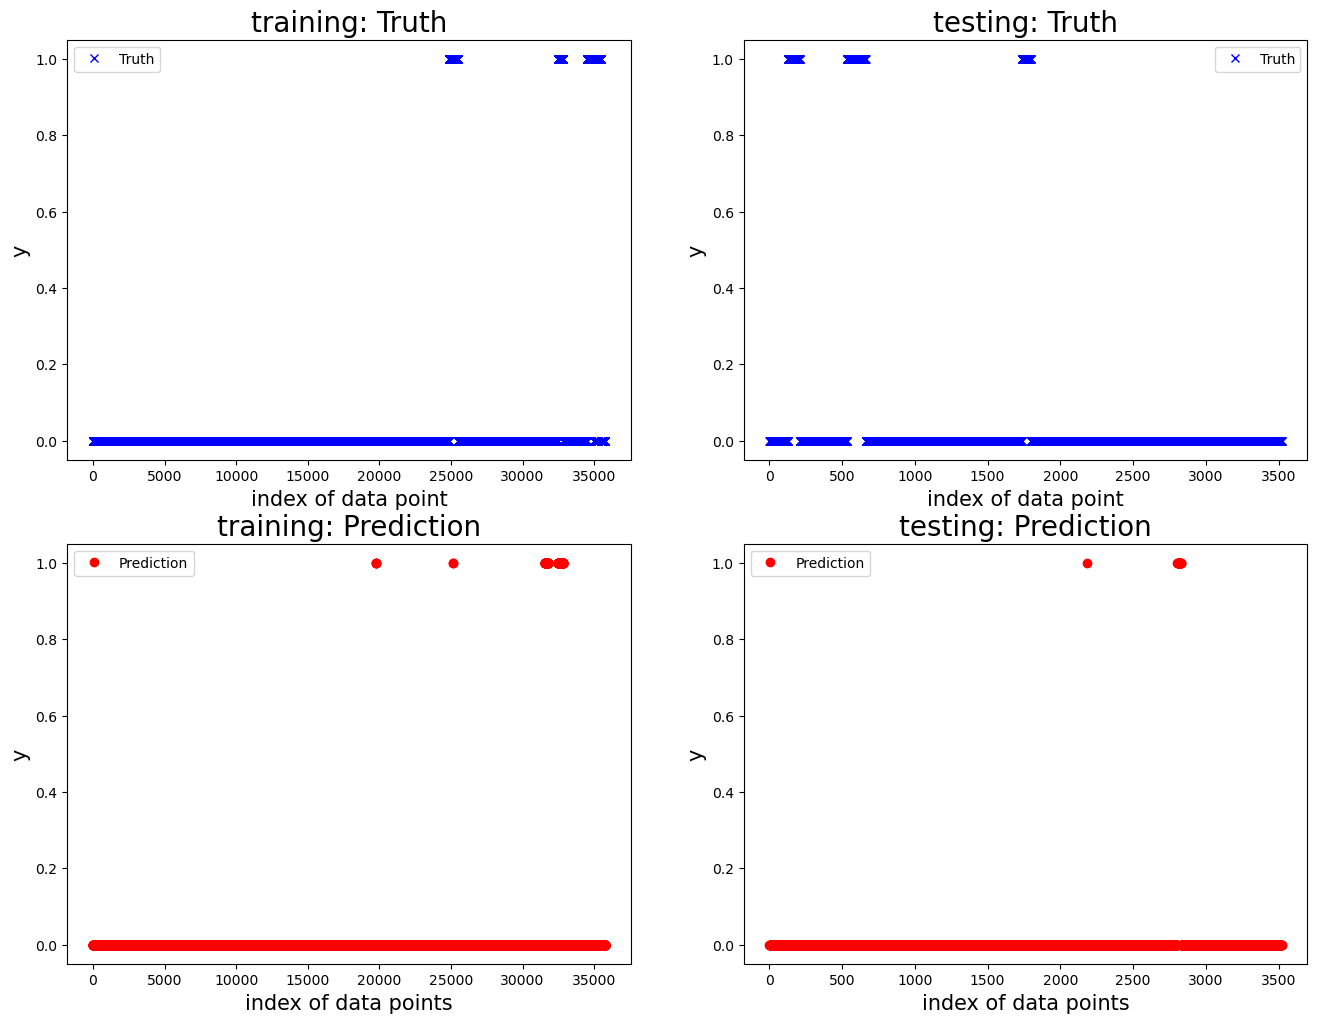


 New run:

training performance, accuracy is: 0.9533189912132916
training performance, precision is: 0.9225806451612903
training performance, recall: 0.07401656314699794
training performance, F1: 0.1370388116914231



 New run:

testing performance, accuracy is: 0.5975274725274725
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




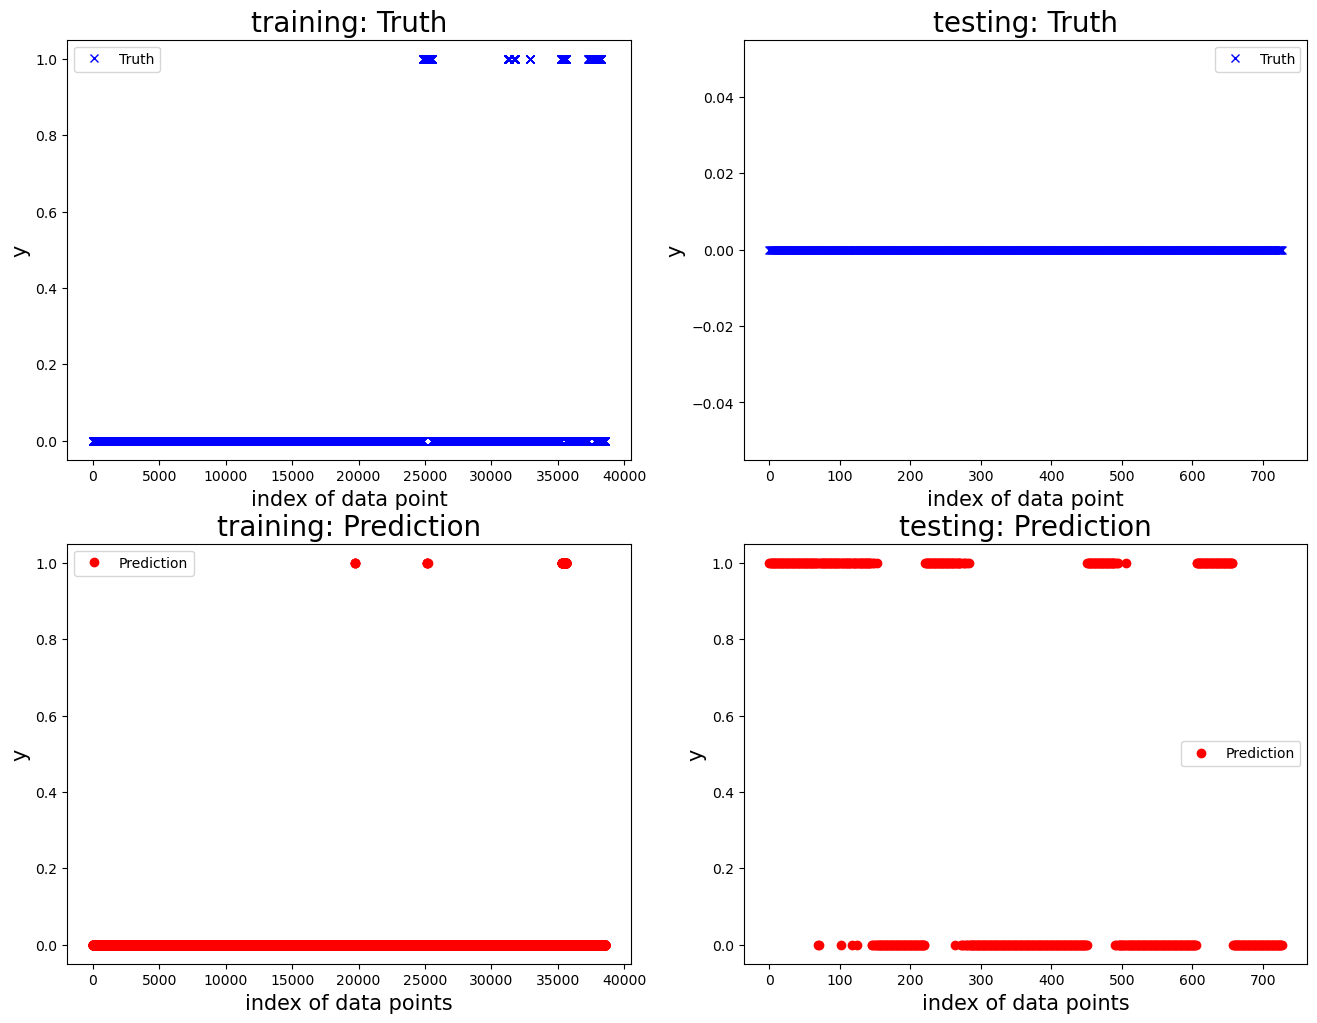


 New run:

training performance, accuracy is: 0.9733220291083793
training performance, precision is: 0.06779661016949153
training performance, recall: 0.004479283314669653
training performance, F1: 0.008403361344537815



 New run:

testing performance, accuracy is: 0.7349643221202854
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




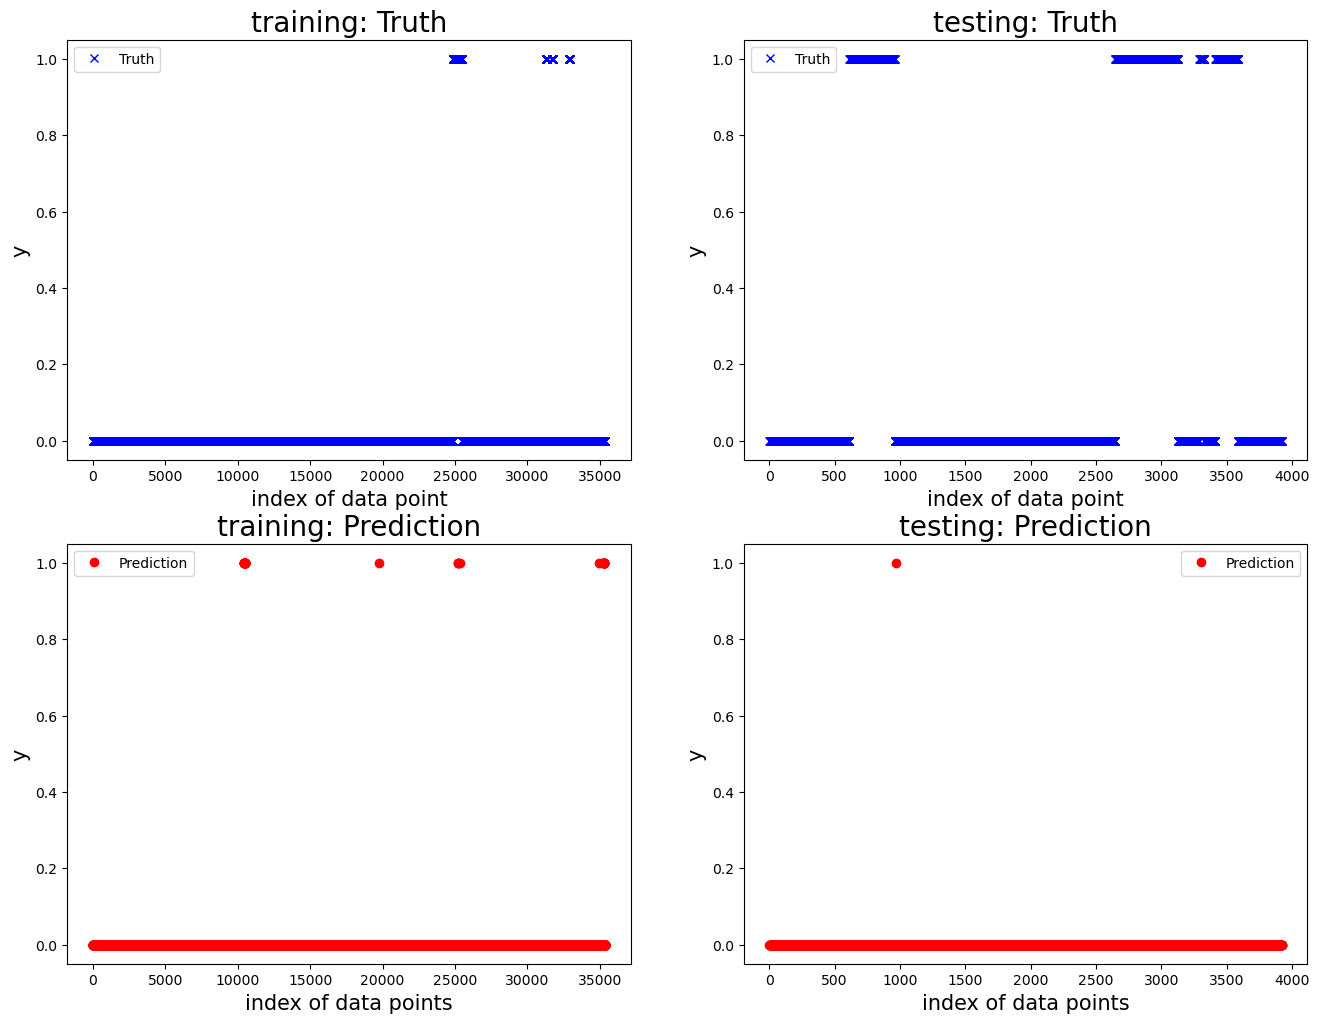

   Accuracy  Precision  Recall  F1 score
0  0.990594        0.0     0.0       0.0
1  0.969456        0.0     0.0       0.0
2  0.914821        0.0     0.0       0.0
3  0.597527        0.0     0.0       0.0
4  0.734964        0.0     0.0       0.0


Mean performance metric and standard error:
Accuracy: 0.8415 +- 0.1694
Precision: 0.0000 +- 0.0000
Recall: 0.0000 +- 0.0000
F1 score: 0.0000 +- 0.0000




In [29]:
from utility import run_cv_one_motor

# Specify the test conditions you would like to include in the test.
df_data_experiment = df_data
# Define the classification model.
mdl = LogisticRegression()

# We want a five-fold cross validation.
n_cv = 5
# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=mdl, feature_list=feature_list_all, n_fold=n_cv)


For each run in the cross validation, the function shows the performance on the training and testing dataset. This can be used for diagnosis and improving the model performance. In the end, the mean performance is printed. 

If you set the parameter `single_run_result=False`, only the final average performance is printed. Plesae note that in the final printed result, we print the mean value and the error bar of the performance metrics. The error bars are calculated as one standard deviation over all the runs.

Looking at the results, the accuracy score is over 80%. Would you see this model as a good model?

# Discussion 3: How could we improve the model performance?

Now, let's try to explore ways of improving the performnace of the model. Note that in this case, the performance of interest is F1 score. 

Let us look at motor 6. And we consider only the seven datasets that contains failure labels of motor 6. Please note that these seven datasets have three operation modes:
- not moving: '20240425_093699', '20240425_094425', '20240426_140055'
- pickup and place: '20240503_163963', '20240325_155003'
- only moving the motor 6: '20240503_164675', '20240503_165189'

## A baseline model.

Below, you can find a baseline model that is based on a seven-fold cross validation. The model considered is a logistic regression but we consider:
- Balanced class weights
- Hyper parameter tuning

In [30]:
from utility import run_cv_one_motor

# Specify the test conditions you would like to include in the test.
df_data_experiment = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced'))    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# We want a five-fold cross validation.
n_cv = 7
# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_all, n_fold=n_cv, single_run_result=False)


Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.423181   0.000000  0.000000  0.000000
1  0.354978   0.354978  1.000000  0.523962
2  0.769643   0.000000  0.000000  0.000000
3  0.060345   0.060345  1.000000  0.113821
4  0.592689   0.000000  0.000000  0.000000
5  0.914858   0.982022  0.910417  0.944865
6  0.272844   0.272844  1.000000  0.428716


Mean performance metric and standard error:
Accuracy: 0.4841 +- 0.2954
Precision: 0.2386 +- 0.3582
Recall: 0.5586 +- 0.5235
F1 score: 0.2873 +- 0.3620




## Increase the feature space by concatenating the features in the past

Additionaly, we can use this program to generate new features by concatenating the features in the past by defining a sliding window. For doing this, you need to use the following parameters:
- window_size: the size of the sliding window. The features in the sliding window are concanetated into a feature vector.
- sample_step: we allow taking features every `sample_step` data points.

Below is a demo of taking every $10$ points in a past interval of $50$ points to create new features and make prediction. You can explore different values of `window_size` and `sample_step` to see how the performance changes.

In [31]:
window_size = 50
sample_step = 10

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_all, 
            n_fold=n_cv, window_size=window_size, sample_step=sample_step, single_run_result=False)

Model for motor 6:
   Accuracy  Precision   Recall  F1 score
0  0.301075   0.000000  0.00000  0.000000
1  0.450549   0.450549  1.00000  0.621212
2  0.747554   0.000000  0.00000  0.000000
3  0.063317   0.063317  1.00000  0.119093
4  0.464545   0.000000  0.00000  0.000000
5  0.840000   0.997462  0.81875  0.899314
6  0.291209   0.291209  1.00000  0.451064


Mean performance metric and standard error:
Accuracy: 0.4512 +- 0.2701
Precision: 0.2575 +- 0.3703
Recall: 0.5455 +- 0.5143
F1 score: 0.2987 +- 0.3624




# Seperate operation mode

In the previous analysis, the dataset contains three different operation modes:
- not moving
- pick-up and place
- only moving motor 6.

In this section, we try to seperate the three operation modes, and train a specific model per operation mode. For each operation mode, we further compare:
- window_size=1: only use current measurement V.S. 
- window_size=50 and sample_step=10: use 50 previous points and sample every 10 points as features.

Let's start by defining a supporting function.

In [32]:
from utility import run_cv_one_motor


# Define a function to run experiment.
def run_experiment(motor_id, df_data, mdl, window_size=1, sample_step=1, n_fold=5):
    print(f'window_size={window_size}, sample_step={sample_step}, all the features.')
    feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
    _ = run_cv_one_motor(motor_id, df_data, mdl, feature_list_all, n_fold=n_fold, window_size=window_size, 
        sample_step=sample_step, single_run_result=False, mdl_type='clf')

    print(f'window_size={window_size}, sample_step={sample_step}, randomly pick features.')
    feature_list_self = ['time', 'data_motor_6_position', 'data_motor_6_temperature', 
                        'data_motor_5_position', 'data_motor_4_position', 'data_motor_3_position', 'data_motor_2_position', 'data_motor_1_position']
    _ = run_cv_one_motor(motor_id, df_data, mdl, feature_list_self, n_fold=n_fold, window_size=window_size, 
        sample_step=sample_step, single_run_result=False, mdl_type='clf')

## Not moving

In [33]:
# Not moving
df_data_mode = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055'])]
n_cv = 3

# Windowsize = 1.
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, n_fold=n_cv)

# Windowsize = 5.
window_size = 50
sample_step = 10
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.935065   0.876404  0.951220  0.912281
1  0.723214   0.453571  0.984496  0.621027
2  0.965517   0.775510  0.603175  0.678571


Mean performance metric and standard error:
Accuracy: 0.8746 +- 0.1320
Precision: 0.7018 +- 0.2208
Recall: 0.8463 +- 0.2112
F1 score: 0.7373 +- 0.1543


window_size=1, sample_step=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.961039   1.000000  0.890244  0.941935
1  0.551786   0.339474  1.000000  0.506876
2  0.060345   0.060345  1.000000  0.113821


Mean performance metric and standard error:
Accuracy: 0.5244 +- 0.4510
Precision: 0.4666 +- 0.4826
Recall: 0.9634 +- 0.0634
F1 score: 0.5209 +- 0.4142


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.450549   0.450549  1.000000  0.621212
1  0.722114   0.473029  0.883721  0.616216
2  0.063

## Move only motor 6.

In [34]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240503_164675', '20240503_165189'])]
n_cv = 2

# Windowsize = 1.
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, n_fold=n_cv)

# Windowsize = 5.
window_size = 50
sample_step = 10
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.198664   0.000000  0.000000  0.000000
1  0.512227   0.011696  0.009434  0.010444


Mean performance metric and standard error:
Accuracy: 0.3554 +- 0.2217
Precision: 0.0058 +- 0.0083
Recall: 0.0047 +- 0.0067
F1 score: 0.0052 +- 0.0074


window_size=1, sample_step=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision   Recall  F1 score
0  0.634391   1.000000  0.54375  0.704453
1  0.272844   0.272844  1.00000  0.428716


Mean performance metric and standard error:
Accuracy: 0.4536 +- 0.2557
Precision: 0.6364 +- 0.5142
Recall: 0.7719 +- 0.3226
F1 score: 0.5666 +- 0.1950


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.127273   0.000000     0.0  0.000000
1  0.292582   0.291609     1.0  0.451544


Mean performance metric and standard error:
Accuracy: 0.2099 +- 0.1169
Precision: 0.1458 +- 0.2062
Re

## Pick up and place

In [35]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240503_163963', '20240325_155003'])]
n_cv = 2

# Windowsize = 0.
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, n_fold=n_cv)

# Windowsize = 5.
window_size = 50
sample_step = 10
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.093055   0.093055     1.0  0.170265
1  0.697998   0.000000     0.0  0.000000


Mean performance metric and standard error:
Accuracy: 0.3955 +- 0.4278
Precision: 0.0465 +- 0.0658
Recall: 0.5000 +- 0.7071
F1 score: 0.0851 +- 0.1204


window_size=1, sample_step=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.093055   0.093055  1.000000  0.170265
1  0.266319   0.276173  0.881844  0.420619


Mean performance metric and standard error:
Accuracy: 0.1797 +- 0.1225
Precision: 0.1846 +- 0.1295
Recall: 0.9409 +- 0.0835
F1 score: 0.2954 +- 0.1770


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.093745   0.093745     1.0  0.171421
1  0.684545   0.000000     0.0  0.000000


Mean performance metric and standard error:
Accuracy: 0.3891 +- 0.4178
Precision: 0.0469 +- 0.0663
Recal

# Data preprocessing considering the time-series features.

## Remove the sequence-to-sequence variablity.

Since the tests are conducted at different time, we cannot garantee that the test conditions are exactly the same. For example, the environment temperature might be different from one test to another and impacts the temperatures of the motors. An easy way to adjust for this variability is to subtract the first value of each sequence from each value of the sequence.

Below is a simple code that implements this idea.

In [37]:
from utility import read_all_test_data_from_path
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline


def compensate_seq_bias(df: pd.DataFrame):
    ''' # Description
    Adjust for the sequence-to-sequence bias.
    '''
    # Tranform the features relative to the first data point.
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
    df['position'] = df['position'] - df['position'].iloc[0]


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()        

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()        

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - Adjust for the sequence-to-sequence bias.
    - add new features about the difference between the current and previous n data point.
    '''     
    # Start processing.
    remove_outliers(df)
    compensate_seq_bias(df)


# Ignore warnings.
warnings.filterwarnings('ignore')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced'))    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Read all the dataset.
base_dictionary = '../maintenance_industry_4_2024/dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

# Specify the test conditions you would like to include in the test.
df_data_experiment = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]

We run the same basic test as Sect. 1. It can be seen from the results that after adjusting the sequence-to-sequence variablity, the results improve significantly.

In [38]:
from utility import run_cv_one_motor

# We want a five-fold cross validation.
n_cv = 7
# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_all, n_fold=n_cv, single_run_result=False)


Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.092754   0.091554  0.980614  0.167471
1  0.952381   0.986301  0.878049  0.929032
2  0.860714   1.000000  0.395349  0.566667
3  0.129310   0.064815  1.000000  0.121739
4  0.542211   0.395322  0.974063  0.562396
5  0.899833   0.903846  0.979167  0.940000
6  0.773488   0.687500  0.311321  0.428571


Mean performance metric and standard error:
Accuracy: 0.6072 +- 0.3638
Precision: 0.5899 +- 0.4073
Recall: 0.7884 +- 0.3008
F1 score: 0.5308 +- 0.3261




## Add change dynamics features

Another possiblity is to add features that consider the change dynamics of the measured data. This can be done by defining a variable $n_int$, and calculate the difference between the current and the previous $n_{int}$ data points. For example, if $n_{int} = 1$, the feature $x_{t-1} - x_t$ is added. If $n_{int} = 2$, the feature $x_{t-2} - x_{t-1} - x_t$ is added.

Below is an example that implements this idea.

In [40]:
from utility import read_all_test_data_from_path
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline

n_int = 20

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    def remove_outliers(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].ffill()        

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
        df['voltage'] = df['voltage'].ffill()        

        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].ffill()


    def cal_diff(df: pd.DataFrame, n_int: int):
        ''' # Description
        Calculate the difference between the current and previous n data point.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]

        # Calculate the difference between the current and previous n data point.
        df['temperature_diff'] = df['temperature'].diff(n_int)
        df['voltage_diff'] = df['voltage'].diff(n_int)
        df['position_diff'] = df['position'].diff(n_int)   

    # Start processing.
    remove_outliers(df)
    cal_diff(df, n_int)


# Ignore warnings.
warnings.filterwarnings('ignore')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced'))    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Read all the dataset.
base_dictionary = '../maintenance_industry_4_2024/dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

# Specify the test conditions you would like to include in the test.
df_data_experiment = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]
n_cv = 7

In [41]:
from utility import run_cv_one_motor

feature_list_selected = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 
                    'data_motor_2_position', 'data_motor_2_temperature', 
                    'data_motor_3_position', 'data_motor_3_temperature', 
                    'data_motor_4_position', 'data_motor_4_temperature', 
                    'data_motor_5_position', 'data_motor_5_temperature', 
                    'data_motor_6_position', 'data_motor_6_temperature', 
                    'data_motor_1_position_diff', 'data_motor_1_temperature_diff', 
                    'data_motor_2_position_diff', 'data_motor_2_temperature_diff', 
                    'data_motor_3_position_diff', 'data_motor_3_temperature_diff', 
                    'data_motor_4_position_diff', 'data_motor_4_temperature_diff', 
                    'data_motor_5_position_diff', 'data_motor_5_temperature_diff', 
                    'data_motor_6_position_diff', 'data_motor_6_temperature_diff']
window_size = 50
sample_step = 10

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_selected, 
            n_fold=n_cv, window_size=window_size, sample_step=sample_step, single_run_result=False)

Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.100714   0.094291  0.995153  0.172260
1  0.882716   1.000000  0.768293  0.868966
2  0.877800   1.000000  0.534884  0.696970
3  0.588718   0.019886  0.111111  0.033735
4  0.580556   0.433750  1.000000  0.605057
5  0.905660   0.905660  1.000000  0.950495
6  0.819209   0.750000  0.594340  0.663158


Mean performance metric and standard error:
Accuracy: 0.6793 +- 0.2899
Precision: 0.6005 +- 0.4195
Recall: 0.7148 +- 0.3305
F1 score: 0.5701 +- 0.3430




# Try yourself:

Could you please try if you could:
- Try to further improve the performance of motor 6?
    - Should we select the features?
    - Should we seperate operation modes?
    - Should we consider the history in the prediciton as well?
    - Should we consider further pre-processing of the data to consider more features regarding the time-series?
        - Adjust for sequence-to-sequence variablity by subtracting the initial values?
        - Add features relating the change velocity?
- implement similar models on the other motors and try to see what would be the best performances we could get?